In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

#create linear svc pipeline with preprocessing
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVC(max_iter=100000, dual=False))])
#create parameter grid with differnt preprocessing and classification parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [4]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [5]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [7]:
#grid search with shuffled k fold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LinearSVC(C=1, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.6725636523266023
grid_kfold_shuffle: test set average accuracy:  0.7017543859649122 



In [8]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.decision_function(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', None),
                ('classifier', LinearSVC(C=0.1, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.6982235571558062
grid_kfold_shuffle test set average precision:  0.7532640326673327 



In [9]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.decision_function(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', None),
                ('classifier', LinearSVC(C=0.1, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.7116728613581568
grid_kfold_shuffle test set AUC:  0.7524630541871921 



Text(0.5, 1.0, 'precision-recall curve for linearSVC (no preprocessing, c=100)')

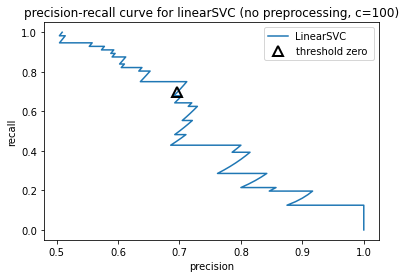

In [10]:
#use no preprocessing and best paramter (C=100) for av. precision
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np

pipe = Pipeline([('preprocessing', None), 
                 ('classifier', LinearSVC(C=0.1, max_iter=100000, dual=False))])

pipe.fit(X_train_cv, y_train_cv)

predict = (pipe.decision_function(X_test_cv))

precision, recall, thresholds = precision_recall_curve(y_test_cv, predict)

plt.plot(precision, recall, label='LinearSVC')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
          markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.title('precision-recall curve for linearSVC (no preprocessing, c=100)')

In [11]:
thresholds

array([-0.63470337, -0.61056256, -0.58564885, -0.58078666, -0.57682624,
       -0.5645029 , -0.55140604, -0.52844437, -0.48684619, -0.48586385,
       -0.47863715, -0.45346647, -0.44280354, -0.39957254, -0.3945127 ,
       -0.36288097, -0.335641  , -0.2988341 , -0.25964767, -0.24353195,
       -0.2420432 , -0.2291054 , -0.22366567, -0.2158913 , -0.21063887,
       -0.20139943, -0.19382891, -0.18788994, -0.15581447, -0.15127153,
       -0.13056311, -0.13019253, -0.12506874, -0.12492029, -0.11562132,
       -0.11362828, -0.10411945, -0.10217217, -0.09767245, -0.09414669,
       -0.09355498, -0.08862943, -0.08322972, -0.07254637, -0.0686638 ,
       -0.06801341, -0.06566446, -0.06024134, -0.05733222, -0.05320222,
       -0.04334212, -0.02375454, -0.01863321, -0.00248564,  0.00225593,
        0.00859134,  0.00860472,  0.02236632,  0.03334174,  0.03509829,
        0.04318712,  0.0451202 ,  0.04861295,  0.06515107,  0.0845429 ,
        0.08783097,  0.09666363,  0.11328033,  0.11596186,  0.13

Text(0.5, 1.0, 'ROC curve for linearSVC (no preprocessing, C=100)')

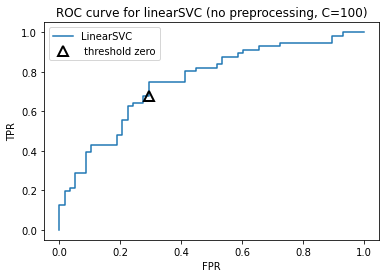

In [12]:
#use no preprocessing and best parameters (c=100) for av. precision

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_cv, pipe.decision_function(X_test_cv))

plt.plot(fpr, tpr, label='LinearSVC')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], '^', c='k',
         markersize=10, label=' threshold zero', fillstyle='none', mew=2)
plt.xlabel('FPR')
plt.ylabel('TPR')#roc curve for best average precision estimator
plt.legend(loc='best')
plt.title('ROC curve for linearSVC (no preprocessing, C=100)')

In [13]:
#confusion matrix (no preprocessing, c=100)

from sklearn.metrics import confusion_matrix

#build and fit pipeline
pipe = Pipeline([('preprocessing', None), 
                 ('classifier', LinearSVC(C=0.1, max_iter=100000, dual=False))])

pipe.fit(X_train_cv, y_train_cv)
predict = pipe.predict(X_test_cv).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_cv, predict)

#calculate precision, sensitivity, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_cv[y_test_cv==0].count())*100
major_error = (confusion[1][0]/y_test_cv[y_test_cv==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.6964285714285714
Sensitivity:  0.6964285714285714
Specificity:  0.7068965517241379
FPR : 0.2931034482758621
very major error : 29.310344827586203
major error:  30.357142857142854

 confusion matrix: 
 [[41 17]
 [17 39]]


In [30]:
# shift decision threshold - not good - produces more false susceptible predictions 
predict = (pipe.decision_function(X_test_cv)>0.4).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_cv, predict)

#calculate precision, sensitivity, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_cv[y_test_cv==0].count())*100
major_error = (confusion[1][0]/y_test_cv[y_test_cv==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.8
Sensitivity:  0.2857142857142857
Specificity:  0.9310344827586207
FPR : 0.06896551724137934
very major error : 6.896551724137931
major error:  71.42857142857143

 confusion matrix: 
 [[54  4]
 [40 16]]


Indirect binary classification via multiclass MIC classification

In [31]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [32]:
# need code to clean up values > 1.6 - need to see if RF can use continuous data

MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_6028/380884722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [33]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

In [34]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [35]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [36]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [37]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [38]:
#build pipeline and paratmeter grid (one vs rest)
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVC(max_iter=100000, dual=False))])
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler()],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}

In [39]:
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LinearSVC(C=0.01, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.2717241379310345
grid_kfold_shuffle: test set average accuracy:  0.2 



In [45]:
from sklearn.metrics import confusion_matrix

#build pipeline and fit
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', LinearSVC(C=0.01, max_iter=100000, dual=False))])

pipe.fit(X_train_cv, y_train_cv)                 
                 
predict = pipe.predict(X_test_nodup)
#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

print ('\n multiclass confusion matrix: \n', confusion)


 multiclass confusion matrix: 
 [[0 0 0 0 0 0 8 1]
 [0 0 0 0 1 0 4 7]
 [0 0 0 0 1 0 5 5]
 [1 0 0 0 2 0 2 6]
 [1 0 0 0 2 0 2 0]
 [0 0 0 0 1 0 0 4]
 [0 0 0 0 1 0 6 2]
 [0 0 0 0 0 0 4 9]]


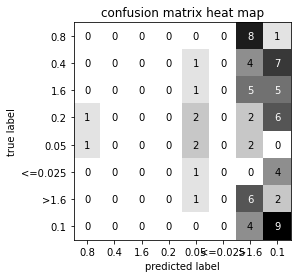

In [46]:
#generate heatmap of confusion matrix for visualisation

import mglearn

target_names = MIC_ML_data['MIC_values'].unique().tolist()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix heat map')
plt.gca().invert_yaxis()

In [47]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.00      0.00      0.00         9
         0.1       1.00      0.00      0.00        12
         0.2       1.00      0.00      0.00        11
         0.4       1.00      0.00      0.00        11
         0.8       0.25      0.40      0.31         5
         1.6       1.00      0.00      0.00         5
     <=0.025       0.19      0.67      0.30         9
        >1.6       0.26      0.69      0.38        13

    accuracy                           0.23        75
   macro avg       0.59      0.22      0.12        75
weighted avg       0.61      0.23      0.12        75



In [48]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {1:['0.2','0.4','0.8','1.6','>1.6'],
           0:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

In [49]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7142857142857143
Sensitivity:  0.6666666666666666
Specificity:  0.6
FPR : 0.4
very major error : inf
major error:  inf

 confusion matrix: 
 [[18 12]
 [15 30]]


C:\Users\user\AppData\Local\Temp/ipykernel_6028/4269136536.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
C:\Users\user\AppData\Local\Temp/ipykernel_6028/4269136536.py:10: RuntimeWarning: divide by zero encountered in longlong_scalars
  major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


In [50]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        30
           1       0.71      0.67      0.69        45

    accuracy                           0.64        75
   macro avg       0.63      0.63      0.63        75
weighted avg       0.65      0.64      0.64        75

